## Rudimentary Avian Magnetoreceptive Navigation Model


#### Original Project Proposal:
BIOL 487 Computational Neuroscience Project Outline – J. Romero (20806791) – Winter 2024
Preface: I wrote condensed literature review paper in PHYS 380 (Molecular and Cellular Biophysics). The paper was titled: Avian Magnetoreception Navigation Systems... In it I discuss the hypothesized mechanism for magnetoreception. Of the two mechanisms, the retinal radical pair-based mechanism is relevant to my project. For the project, I will be considering a 2- dimensional representation 3-dimensional system discussed in my paper.
Candidate Title: Avian magneto-receptive home-point navigation: A 2-Dimensional representation and analysis.

Project Overview: I will model the magnetic field using vector field. The retina is modeled as a line segment, with a slight curve, in the magnetic field where the strength of the field at any point on the retina is proportional to the dot product to the magnetic field. Any ‘view’ is associated with the special coordinates and an azimuthal direction. The system is then set up with a convolutional neural network, trained on randomly generated point direction data. The model is tested on how many steps it takes to get within a certain radius of the ‘home location’ from the ‘view’ provided by the line segment, where the CNN is tweaked to minimize the step number of steps necessary to travel to the home point.

#### Professor feedback
If I'm reading this correctly, **the convolutional NN will be used to map the magentic field image on the synthetic retina to specific coordinates (x,y,theta)**. If that is the case, this is good. If you are planning on building a model that navigates, we need to quickly determine how much effort this will be and plan to descope as needed.

Additionally, it isn't enough just to build a model to do something, you need to modify the model so it has some greater or less resemblance to biology, and you need to compare against it.

---


We start by defining a bird that can exist in 2-dimensional space.


We start by defining a function that can generate a vector field to represent the magnetic field.

We begin by considering a simple magnetic field which which points north at all points in 2-dimensional space. In this case the equation for the magnetic field vector at any point is:

$ \vec{B} = B_0 * \hat{j}$

Where $B_0$ is the strength of the magnetic field at any given point as it is uniform at all points in space and $\hat{j}$ is a unit vector pointing north.

However, this vector field does not provide a lot of information about location. To aid in this, we can model the magnetic field as a non-uniform vector field that converges at points closer to the north pole. In this case, the vector field is given by:

$ \vec{B}(x, y) = (B_0  + \alpha*y)\hat{j} - (\beta * y * \frac{x}{|x|}))\hat{i} $

Where $ \alpha $ determines the rate at which the magnetic field increases with increasing y and $ \beta $ determines the rate at which the magnetic field lines converge with increasing y.




In [2]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## We define a class that represents a 2D magnetic field.
## Note that in order to map a the earth's spherical surface onto a 2D plane, we include the x component's depedence on x which causes
## variablity in the magnetic field along the x axis. This simply accounts for the fact that the bird is not at the centre line at
## all times.
class magnetic_field_2D:
    def __init__(self, B_not, alpha, beta, x_min, x_max, y_min, y_max, x_dependance=0.01):
        self.B_not = B_not
        self.alpha = alpha
        self.beta = beta
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.x_dependance = x_dependance

        ## We create a 2D magnetic field representation at initialization.
        self.mag_field_space = self._mag_field_create()

    ## We define function for the 2D represenation of the magnetic field.
    ##  Note: This function is NOT a plane in 3D space with a magnetic field.
    ##        It is a 2D representation of the magnetic field that resembles a 3D magnetic field.
    def _2D_magnetic_field_represenation(self, x, y):
        y_component = (self.B_not + self.alpha * y)
        x_component = -(self.beta * y * (self.x_dependance * x))  ## Note the x component is now dependent on x
        return x_component, y_component

    ## Define a function to create a 2D magnetic field representation at initialization.
    def _mag_field_create(self):
        x = np.linspace(self.x_min, self.x_max, 20)
        y = np.linspace(self.y_min, self.y_max, 20)
        X, Y = np.meshgrid(x, y)
        Bx, By = self._2D_magnetic_field_represenation(X, Y)
        return ([X, Y], [Bx, By])

    def mag_field_interpolate(self, x, y):
        assert x >= self.x_min and x <= self.x_max, "x value out of range"
        assert y >= self.y_min and y <= self.y_max, "y value out of range"

        # Coordinates of the magnetic field space
        X = self.mag_field_space[0][0]
        Y = self.mag_field_space[0][1]

        # Magnetic field components
        B_x = self.mag_field_space[1][0]
        B_y = self.mag_field_space[1][1]

        # Interpolating the magnetic field components
        B_y_i = griddata((X.flatten(), Y.flatten()), B_y.flatten(), (x, y), method='cubic')
        B_x_i = griddata((X.flatten(), Y.flatten()), B_x.flatten(), (x, y), method='cubic')

        return B_x_i, B_y_i
    
    def plot_magnetic_field(self):
        X = self.mag_field_space[0][0]
        Y = self.mag_field_space[0][1]
        B_x = self.mag_field_space[1][0]
        B_y = self.mag_field_space[1][1]
        plt.figure()
        plt.quiver(X, Y, B_x, B_y)
        plt.title('2D magnetic field representation')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
    
    def __str__(self) -> str:
        return f"2D magnetic field representation with B_not={self.B_not}, alpha={self.alpha}, beta={self.beta} and x_dependance={self.x_dependance}"
    
    def destroy(self):
        del self


We create our magnetic field adding complexity with each step, ending with a call to the magnetic field representaton class that will be used in he project.

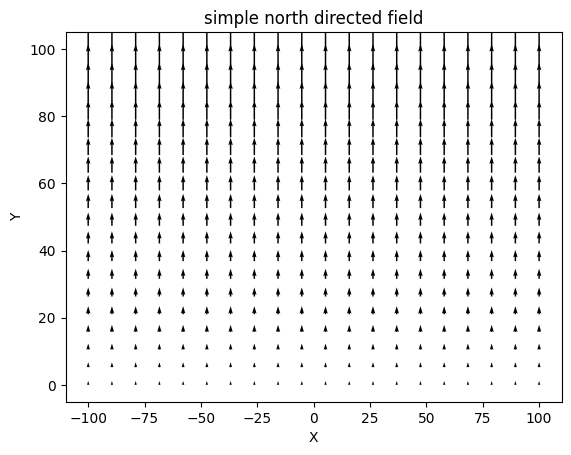

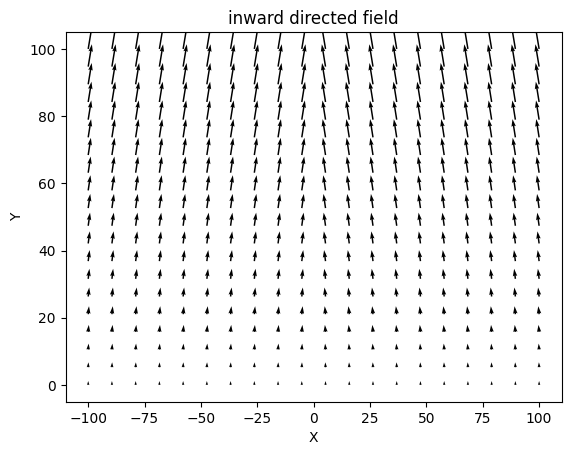

2D magnetic field representation with B_not=5, alpha=0.1, beta=0.02 and x_dependance=0.03


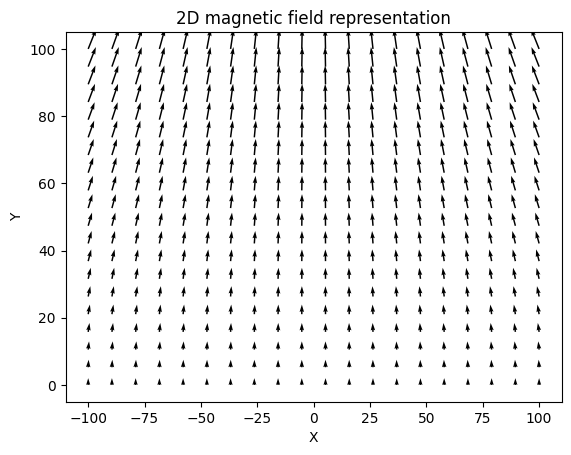

In [4]:
## We define a magnetic field as shown above, which portrays what at the centre line (x = 0) may experience. 
def mag_field_point(x, y, B_not, alpha, beta):
    y_component = (B_not + alpha * y)
    x_component = -(beta * y * np.sign(x))

    return [x_component, y_component]

## Let's create a plot to visualize the magnetic field
# Define the range of x and y values
x = np.linspace(-100, 100, 20)
y = np.linspace(0, 100, 20)

# Create a meshgrid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate a basic magnetic vector field where the field at all points is directed towards north.
U1, V1 = mag_field_point(X, Y, B_not=2, alpha=0.1, beta=0)

# Calculate the magnetic field vectors that point inward towards the centre line.
U2, V2 = mag_field_point(X, Y, B_not=2, alpha=0.1, beta=0.02)

# Plotting simple north directed field.
plt.figure()
plt.quiver(X, Y, U1, V1)
plt.title('simple north directed field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plotting inward directed field.
plt.figure()
plt.quiver(X, Y, U2, V2)
plt.title('inward directed field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## No we can use the magnetic_field_2D class to create a 2D magnetic field representation.
##  Note The key difference here is he the x component is dependent on x, which causes the
##  magnetic field to vary along the x axis. This is done to account for the fact that the 
##  bird is not at the centre line at all times. In a 3D representation, the magnetic field
##  would be uniform along the x axis (which would be the latitudinal axis in a 3D representation).
mag_field = magnetic_field_2D(B_not=5, alpha=0.1, beta=0.02, x_min=-100, x_max=100, y_min=0, y_max=100, x_dependance=0.03)
print(mag_field)
mag_field.plot_magnetic_field()
mag_field.destroy()

Above we can see that its somewhat challenging to model the differential nature of a 3-dimensional magnetic field in 2 dimensions but it can be accomplished with some fidelity. I'll note that the earths magnetic field varies in all 3 dimentions dependant on the position on earth. That is, at the equator it is weaker and more simply directed northward but as one approaches the equator, the downward (or earthward) incliation of the field begins to gain more relevance and likely provide important queues in migrational navigation.

In [5]:
import numpy as np

## Bird class
class Bird:
    def __init__(self, position, direction):
        self.position = [position[0], position[1]] ## x, y
        self.direction = direction ## NOTE Angle in radians from the positive x-axis

    # Move the bird by a certain distance
    def move(self, distance):
        self.position[0] += distance * np.cos(self.direction)
        self.position[1] += distance * np.sin(self.direction)
    

    def move_to_position(self, position, direction=None):
        self.position = position
        if direction is not None:
            self.direction = direction

    # The bird's retina model for 3 points at its current position and direction
    def bird_view_points(self):
        bird_position = self.position
        bird_direction = self.direction

        # Calculate displacement vector
        dx = 0.1 * np.cos(bird_direction)
        dy = 0.1 * np.sin(bird_direction)

        # Calculate coordinates of the first point
        x1 = bird_position[0] + dx
        y1 = bird_position[1] + dy

        # Calculate displacement vectors for the other two points
        dx1 = 0.2 * np.cos(bird_direction + np.pi/2)
        dy1 = 0.2 * np.sin(bird_direction + np.pi/2)
        dx2 = 0.2 * np.cos(bird_direction - np.pi/2)
        dy2 = 0.2 * np.sin(bird_direction - np.pi/2)

        # Calculate coordinates of the second point
        x2 = x1 + dx1 + 0.5 * dx
        y2 = y1 + dy1 + 0.5 * dy

        # Calculate coordinates of the third point
        x3 = x1 + dx2 + 0.5 * dx
        y3 = y1 + dy2 + 0.5 * dy

        p1 = [x1, y1]
        p2 = [x2, y2]
        p3 = [x3, y3]

        return p1, p2, p3 # Return the 3 points, where the centre point is p1
        # # Print the coordinates of the three points
        # print("Point 1: ({}, {})".format(x1, y1))
        # print("Point 2: ({}, {})".format(x2, y2))
        # print("Point 3: ({}, {})".format(x3, y3))

    # Bird's magnetic field using the 3-point retina model from above
    def bird_magview(self, mag_field):
        p1, p2, p3 = self.bird_view_points()

        # Reminder that p1 is the centre point
        B1 = mag_field.mag_field_interpolate(p1[0], p1[1])
        B2 = mag_field.mag_field_interpolate(p2[0], p2[1])
        B3 = mag_field.mag_field_interpolate(p3[0], p3[1])

        # Magnetic fields are dotted with the displacement vectors to get the magnetic flux
        flux1 = np.dot(B1, [np.cos(self.direction), np.sin(self.direction)])
        flux2 = np.dot(B2, [np.cos(self.direction), np.sin(self.direction)])
        flux3 = np.dot(B3, [np.cos(self.direction), np.sin(self.direction)])

        return flux1, flux2, flux3
   
    def __str__(self):
        return "Bird at position ({}, {}) facing {} degrees".format(self.position[0], self.position[1], self.direction)
    
    def destroy(self):
        del self
    


In [6]:
import random
import numpy as np

## A function that generates a random bird's position within a given range.
def generate_bird_position(x_min, x_max, y_min, y_max):
    x = random.uniform(x_min, x_max)
    y = random.uniform(y_min, y_max)
    return [x, y]


## A function that generates a random bird's direction within a given range, in radians.
def generate_bird_direction():
    return random.uniform(0, np.pi*2)


## A function that returns the turn angle the bird must make to face the home point in radians.
def bird_turn_to_home(current_direction, current_position, home_point):
    # calculate the direction angle in radians
    direction_rad = np.arctan2(home_point[1] - current_position[1], home_point[0] - current_position[0])
    
    # calculate the turn angle in radians
    turn_rad_unnormalized = direction_rad - current_direction

    bird_turn_rad = (turn_rad_unnormalized + np.pi) % (2 * np.pi) - np.pi
    
    assert bird_turn_rad >= -np.pi and bird_turn_rad <= np.pi, "Turn angle is not within -pi and pi"

    return bird_turn_rad


## generate_training_data
## Input: n_samples, x_min, x_max, y_min, y_max, mag_field_func
## Generates a random home point,
##   then n random bird positions with direction vectors for n samples
##   calculates the direction the bird must travel in order to reach the home point
##   and returns the training data as a list of tuples
def generate_training_data(n_samples, x_min, x_max, y_min, y_max, mag_field_space):
    home_point = generate_bird_position(x_min, x_max, y_min, y_max)
    
    # training_data = []
    points = []
    directions = []
    mag_images_unnormalized = []
    mag_vector_lengths = []
    turn_to_home_thetas = [] # List for turn angles normalized between -pi and pi

    # Data creation loop (does not normalize the magnetic field picture)
    for _ in range(n_samples):
        # Random spot generated with a 1 unit margin from the edges (to avoid edge cases from retina model)
        rand_spot = generate_bird_position(x_min=(x_min + 1), x_max=(x_max - 1), y_min=(y_min + 1), y_max=(y_max - 1))
        # Magnetic field at the random spot (this assumes the bird has already oriented itself in the direction of the magnetic field)
        mag_field_vector = mag_field_space.mag_field_interpolate(rand_spot[0], rand_spot[1])

        # Magnetic field magnitude at the random spot (as sensed by beak magnetite receptors)
        mag_field_magnitude = np.linalg.norm(mag_field_vector)
        mag_vector_lengths.append(mag_field_magnitude)

        bird_position = rand_spot # Place the bird at the random spot
        bird_direction = np.arctan2(mag_field_vector[1], mag_field_vector[0]) # Bird faces the magnetic field

        # Append the random spot and direction to the points and directions lists
        points.append(bird_position)
        directions.append(bird_direction)

        # Create a bird at the random point and direction, then
        #  check it's magnetic view at that point to be stored.
        bird = Bird(bird_position, bird_direction) # Create a bird at the random spot and facing the magnetic field
        flux1, flux2, flux3 = bird.bird_magview(mag_field_space) # Magnetic field image (flux values) at the bird's retina
        bird.destroy()

        # Append the unnormalized magnetic field picture to a temporary list
        mag_image = [flux1, flux2, flux3] # Unnormalized magnetic field picture
        mag_images_unnormalized.append(mag_image)    
        
        # Calculate the turn angle the bird must make to face the home point
        turn_to_home_theta_in_radians = bird_turn_to_home(bird_direction, bird_position, home_point)
        # # Normalize the turn angle to between -1 and 1
        # turn_to_home_theta_normalized = turn_to_home_theta_in_radians / np.pi
        # Append the normalized turn angle to the list
        turn_to_home_thetas.append(turn_to_home_theta_in_radians)
        
    # Normalize the magnetic field picture using the min-max normalization
    ## First create a long 1-dimensional list of the flux values
    ##   Remembering that every triplet along the line is one image
    mag_images_unnormalized_1D = []
    for image in mag_images_unnormalized:
        for flux in image:
            mag_images_unnormalized_1D.append(flux)

    ## Find the max and min values of the flux values and apply min-max normalization
    max_val = max(mag_images_unnormalized_1D)
    min_val = min(mag_images_unnormalized_1D)
    mag_images_normalized = []
    for flux_value in mag_images_unnormalized_1D:
        # Normalize the flux values to between -1 and 1
        normalized_flux_value = (((flux_value - min_val) / (max_val - min_val)) * 2) - 1
        mag_images_normalized.append(normalized_flux_value)
    # Reshape the normalized magnetic field pictures to their original shape (array of 3 arrays)
    mag_images_normalized = np.array(mag_images_normalized).reshape(n_samples, 3)

    # Notmalize the magnetic field strengths using min-max normalization
    max_strength = max(mag_vector_lengths)
    min_strength = min(mag_vector_lengths)
    mag_strengths_normalized = []
    for strength in mag_vector_lengths:
        normalized_strength = 0 + ((strength - min_strength) / (max_strength - min_strength)) * (3 - 0) # Normalize to between a = 0 and b = 3
        mag_strengths_normalized.append(normalized_strength)

    return home_point, (points, directions, mag_images_normalized, mag_strengths_normalized, turn_to_home_thetas)



In order to model the bird's ability to face the home direction, we have to be able to model the bird's ability to properly orient itself toward the magnetic field. For this, we can create an action model capable of detecting the magnetic field vector's direction, catagorically, using a winner-take-all approach.

In [7]:
## Let's generate a small set of training data
mag_field = magnetic_field_2D(B_not=5, alpha=0.1, beta=0.02, x_min=-100, x_max=100, y_min=0, y_max=100, x_dependance=0.03)
dataset_reorientation_problem = generate_training_data(10, x_min=-100, x_max=100, y_min=0, y_max=100, mag_field_space=mag_field)

## We can now catagorize the bird's direction to the magnetic field into 8 directions as follows:
## 0: -180 to -135 degrees
## 1: -135 to -90 degrees
## 2: -90 to -45 degrees
## 3: -45 to 0 degrees
## 4: 0 to 45 degrees
## 5: 45 to 90 degrees
## 6: 90 to 135 degrees
## 7: 135 to 180 degrees
def catagorize_direction(direction):
    slice = np.pi / 4
    slices = np.arange(-np.pi, np.pi, slice)
    for i in range(len(slices) - 1):
        if direction >= slices[i] and direction < slices[i + 1]:
            return i
    return 7

## We can now catagorize the bird's direction to the magnetic field into 8 directions.
catagorized_mag_field_directions = []
for direction in dataset_reorientation_problem[1][1]:
    catagorized_mag_field_directions.append(catagorize_direction(direction))

## Now that we have the the catagory for each direction, we can create a one-hot encoding for each catagory.
def one_hot_encoding(catagories):
    one_hot_encoded = []
    for catagory in catagories:
        one_hot = [0] * 8
        one_hot[catagory] = 1
        one_hot_encoded.append(one_hot)
    return one_hot_encoded

## One hot encoding of the catagorized magnetic field directions
one_hot_encoded_mag_field_directions = one_hot_encoding(catagorized_mag_field_directions) # Data labels


for bird in range(len(dataset_reorientation_problem[1][0])):
    print("Bird at position ({}, {}) facing {} degrees".format(dataset_reorientation_problem[1][0][bird][0], dataset_reorientation_problem[1][0][bird][1], dataset_reorientation_problem[1][1][bird] * 180 / np.pi))
    print("Magnetic field direction catagory: {}".format(catagorized_mag_field_directions[bird]))



    



Bird at position (-20.086891140387394, 97.03192296727896) facing 85.45614990199545 degrees
Magnetic field direction catagory: 5
Bird at position (-54.9425079666857, 3.8308452329297014) facing 88.64893829542703 degrees
Magnetic field direction catagory: 5
Bird at position (24.920088587720343, 58.42800566875921) facing 94.60740308527566 degrees
Magnetic field direction catagory: 6
Bird at position (-22.48981306463355, 46.77854325918584) facing 86.26903878602741 degrees
Magnetic field direction catagory: 5
Bird at position (81.60714369983478, 48.29639133252228) facing 103.528259650784 degrees
Magnetic field direction catagory: 6
Bird at position (-54.81559189809609, 92.26349463202806) facing 77.95977997098603 degrees
Magnetic field direction catagory: 5
Bird at position (-98.07256586747108, 59.97244743976819) facing 72.20985251350038 degrees
Magnetic field direction catagory: 5
Bird at position (-33.81190643283412, 63.698440522561) facing 83.51731020162822 degrees
Magnetic field direction

In the model, it became clear that passing only the flux image to the model was not enough to asertain the birds positions, let alone the birds position with respect to its direction with respect to the home point. This is because the normalized flux values only provide information about the magnetic field's orientation to the bird. We need to pass the model a representation of the STRENGTH of the magnetic field at each point, as well as to make sure that the bird is oriented in the direction of the magnetic field in order to reduce the variability that comes with placing the bird at a random direction. Luckily, this follows naturally since above we used a winner take all model to orient the bird roughly in the direction of the magnetic field.

In [20]:
## Generate training and testing data
mag_field = magnetic_field_2D(B_not=5, alpha=0.1, beta=0.02, x_min=-100, x_max=100, y_min=0, y_max=100, x_dependance=0.05)
dataset = generate_training_data(10000, x_min=-100, x_max=100, y_min=0, y_max=100, mag_field_space=mag_field)

print("Home point:", dataset[0])
print("Bird Points:", dataset[1][0][:5])
print("Bird Directions:", dataset[1][1][:5])
print("Magnetic field images:", dataset[1][2][:5])
print("Magnetic field strengths:", dataset[1][3][:5])
print("Turn to home thetas:", dataset[1][4][:5])

mag_field.destroy()

Home point: [-41.33798453910562, 27.68102330990343]
Bird Points: [[8.325166995011898, 94.37628115843253], [-45.942675055070445, 88.45548923719082], [-21.013795036138845, 34.11096038315598], [30.869627722059477, 65.71220860504445], [79.72817125939264, 80.1057860424034]]
Bird Directions: [1.6250996114193175, 1.2853333591906335, 1.485542432230116, 1.7443213672420372, 2.0271250049134815]
Magnetic field images: [[ 0.49153996  0.49199975  0.49267239]
 [ 0.4868095   0.48932944  0.48584614]
 [-0.46750614 -0.46633434 -0.46707002]
 [ 0.05940162  0.05927209  0.06113073]
 [ 0.49701393  0.49501846  0.50055007]]
Magnetic field strengths: [2.242052410689229, 2.234996329353448, 0.8004120271346437, 1.5924604305204304, 2.2503606295255705]
Turn to home thetas: [2.4472352622589817, -2.780507310438016, 1.9624556920075786, 1.882043919947284, 1.5231164903375856]


In [ ]:
# mag_field = magnetic_field_2D(B_not=10, alpha=0.1, beta=0.02, x_min=-100, x_max=100, y_min=0, y_max=100, x_dependance=0.05)
# dataset = generate_training_data(1000, x_min=-100, x_max=100, y_min=0, y_max=100, mag_field_space=mag_field)
# mag_field.destroy()

In [ ]:
# import pickle
# ## Now we save the dataset to a file to avoid regenerating it every time
# with open('dataset_10000.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

In [ ]:
# import pickle
# ## In other sessions we can load the dataset from the file
# dataset = None
# with open('dataset_10000.pkl', 'rb') as f:
#     dataset = pickle.load(f)


# # Print dataset to verify it was loaded correctly
# print("The dataset length is",len(dataset[1][0]))
# print("Home point:", dataset[0])
# print("Bird Points:", dataset[1][0][:5])
# print("Bird Directions:", dataset[1][1][:5])
# print("Magnetic field pictures:", dataset[1][2][:5])
# print("Turn to home thetas:", dataset[1][3][:5])



In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [22]:


images = dataset[1][2]  # Extracting the magnetic field images
strengths = dataset[1][3]  # Extracting the magnetic field strengths
theta_labels = dataset[1][4]  # Extracting the turn to home thetas
bird_magnetoreception_data = [[m1, m2, m3, strength] for (m1, m2, m3), strength in zip(images, strengths)] # Creating the combined input tensor

X = torch.tensor(bird_magnetoreception_data, dtype=torch.float32) # Convert to a PyTorch tensor
Y = [theta for theta in theta_labels] # Turn to home thetas in radians from the positive x-axis
dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Y)) # create your datset

train_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.8,0.2])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)




In [ ]:
inputs, targets = next(iter(train_loader))
inputs.shape, targets.shape

In [23]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, depth, output_size):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        # Add the first layer (input layer)
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Add hidden layers based on the specified depth
        for _ in range(depth - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Add the output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        # Apply ReLU to all but the last layer
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        # No activation function on the output layer
        x = self.layers[-1](x)
        return x

    
    # def initialize_weights(model):
    #     for param in model.parameters():
    #         torch.nn.init.zeros_(param)




In [24]:
def train_network(network, train_loader_data, num_epochs, learning_rate):
    criterion = nn.MSELoss() # Mean Squared Error Loss for continuous values
    train_loss = []

    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.5)

    for epoch in range(num_epochs):
        network.train()
        epoch_loss = []
        for _, data in enumerate(train_loader_data, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels) ## labels are the turn to home thetas
            loss.backward()
            if _ // 10 == 0:
                with torch.no_grad():
                    print("Output: {} Label: {}".format(outputs, labels))
                    train_loss.append(loss.detach().numpy())


            optimizer.step()
            epoch_loss.append(loss.item())

        print("Epoch: {} Loss: {}".format(epoch, sum(epoch_loss)/len(epoch_loss)))

    ## Plot the training loss
    plt.plot(train_loss)
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

    return network



def test_network(network, test_loader):
    network.eval()  # Set the network to evaluation mode
    criterion = nn.MSELoss() # Mean Squared Error Loss for continuous value

    test_loss = []
    with torch.no_grad(): # No need to calculate the gradients for testing
        for _, data in enumerate(test_loader, 0):
            inputs, labels = data
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())
            print("Loss: {}".format(loss.item()))

# Plot the test loss
    plt.plot(test_loss)
    plt.title('Test Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

    return test_loss



In [32]:
## Experiment to find the best magnetic field strencth for the birds to navigate
##  We will train the network with different magnetic field strengths and compare the results
##  We will use the best magnetic field strength to train the network and test the network
##  with the test data to see how well the network performs
def experiment_magnetic_field_strengths(train_loader, test_loader, input_size, hidden_size, depth, output_size, num_epochs, learning_rate, magnetic_field_strengths, bird_magnetoreception_data, theta_labels):
    best_loss = 1000000 # Initialize the best loss to a large value
    best_network = None # Initialize the best network to None
    best_magnetic_field_strength = None # Initialize the best magnetic field strength to None
    for magnetic_field_strength in magnetic_field_strengths:
        print("Training network with magnetic field strength: {}".format(magnetic_field_strength))
        bird_magnetoreception_data = [[m1, m2, m3, magnetic_field_strength] for (m1, m2, m3), _ in zip(images, strengths)] # Creating the combined input tensor
        X = torch.tensor(bird_magnetoreception_data, dtype=torch.float32) # Convert to a PyTorch tensor
        Y = [theta for theta in theta_labels] # Turn to home thetas in radians from the positive x-axis
        dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Y)) # create your datset

        train_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.8,0.2])

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

        network = Net(input_size, hidden_size, depth, output_size)
        trained_network = train_network(network, train_loader, num_epochs, learning_rate)
        test_loss = test_network(trained_network, test_loader)

        if sum(test_loss) < best_loss:
            best_loss = sum(test_loss)
            best_network = trained_network
            best_magnetic_field_strength = magnetic_field_strength

    print("Best magnetic field strength: {}".format(best_magnetic_field_strength))
    return best_network, best_magnetic_field_strength


## Experiment to find the best network hyperparameters
##  We will train the network with different hyperparameters and compare the results
##  We will use the best hyperparameters to train the network and test the network
##  with the test data to see how well the network performs
def experiment_network_hyperparameters(train_loader, test_loader, input_size, hidden_sizes, depths, output_size, num_epochs, learning_rates):
    best_loss = 1000000 # Initialize the best loss to a large value
    best_network = None # Initialize the best network to None
    best_hyperparameters = None # Initialize the best hyperparameters to None
    for hidden_size in hidden_sizes:
        for depth in depths:
            for learning_rate in learning_rates:
                print("Training network with hidden size: {}, depth: {}, learning rate: {}".format(hidden_size, depth, learning_rate))
                network = Net(input_size, hidden_size, depth, output_size)
                trained_network = train_network(network, train_loader, num_epochs, learning_rate)
                test_loss = test_network(trained_network, test_loader)

                if sum(test_loss) < best_loss:
                    best_loss = sum(test_loss)
                    best_network = trained_network
                    best_hyperparameters = (hidden_size, depth, learning_rate)

    print("Best hyperparameters: {}".format(best_hyperparameters))
    return best_network, best_hyperparameters


In [ ]:
import pickle
best_net_mag, best_hyperparameters_mag_test = experiment_magnetic_field_strengths(train_loader, test_loader, input_size=4, hidden_size=100, depth=6, output_size=1, num_epochs=300, learning_rate=0.1e-5, magnetic_field_strengths=[2, 4, 8, 16, 32, 64, 128, 256], bird_magnetoreception_data=bird_magnetoreception_data, theta_labels=theta_labels)

best_net_param, best_hyperparameters_param_test = experiment_network_hyperparameters(train_loader, test_loader, input_size=4, hidden_sizes= [50, 100, 200], depths=[3, 9, 18, 24], output_size=1, num_epochs=300, learning_rates=[0.1e-3, 0.5e-5, 1e-8])

best_mag_field_strength = best_hyperparameters_mag_test
best_hidden_size, best_depth, best_learning_rate = best_hyperparameters_param_test

# best_mag_field_strength = 5
## Iterate to create larger datasets, saving them to files
dataset_sizes = [10, 100, 1000, 10000, 100000, 1000000]
for dataset_size in dataset_sizes:
    mag_field = magnetic_field_2D(B_not=best_mag_field_strength, alpha=0.1, beta=0.02, x_min=-100, x_max=100, y_min=0, y_max=100, x_dependance=0.05)
    dataset = generate_training_data(dataset_size, x_min=-100, x_max=100, y_min=0, y_max=100, mag_field_space=mag_field)
    print("Dataset size: {}".format(dataset_size))
    mag_field.destroy()

    with open('dataset_{}.pkl'.format(dataset_size), 'wb') as f:
        pickle.dump(dataset, f)

In [ ]:
## Load the datasets from the files
datasets = [] # List to store the datasets of sizes 10, 100, 1000, 10000, 100000, 1000000
for dataset_size in dataset_sizes:
    dataset = None
    with open('dataset_{}.pkl'.format(dataset_size), 'rb') as f:
        dataset = pickle.load(f)
    datasets.append(dataset)
    print("Loaded dataset of size: {}".format(dataset_size))



In [ ]:
## Create the network
Magnetoreception_network = Net(input_size=4, hidden_size=100, depth=12, output_size=1)

## Train the network
network_trained = train_network(Magnetoreception_network, train_loader_data=train_loader, num_epochs=120, learning_rate=1e-5)

## Test the network
test_loss = test_network(network_trained, test_loader)